In [62]:
import os

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [4]:
# Set up visualization style
plt.style.use("seaborn-v0_8-notebook")
sns.set_palette("husl")
%matplotlib inline

In [3]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

### *Load data and perform initial inspection*

In [14]:
#  Loading and inspecting data...
df = pd.read_csv("../data/processed/training_data.csv")

In [15]:
# Initial data inspection
print(f"\n🔍 Data Shape: {df.shape}")
print("\n📋 First 5 rows:")
display(df.head())


🔍 Data Shape: (140, 16)

📋 First 5 rows:


,patient,gender,age,marital_status,race,ethnicity,death_flag,num_encounters,recent_encounter_type,avg_encounter_cost,num_conditions,chronic_disease_flag,num_medications,avg_med_cost,total_med_cost,readmitted
0,f4db39b1-693d-e301-0a1f-41d26d3ced36,M,40,S,white,nonhispanic,0,55,outpatient,100.247455,21,1,11,498.663636,6279.27,0
1,e8503522-82ff-67a2-4dad-29281d6318de,M,60,M,white,nonhispanic,0,63,wellness,120.049048,61,1,146,0.717466,2243.87,0
2,ac643af6-1a32-08ce-df40-1c31348bcb41,M,60,M,white,nonhispanic,0,52,wellness,127.526923,53,1,43,0.425814,166.38,1
3,358f26b9-a982-0346-55d3-65e8667f39e9,F,71,S,white,hispanic,0,72,wellness,128.202083,37,1,13,250.130769,22400.91,0
4,1017741e-00f0-e3dc-5c93-f5b0053f2cc4,M,71,M,white,nonhispanic,0,56,wellness,111.548929,47,1,20,0.199000,6.05,0


In [16]:
print("\n📈 Data Summary:")
display(df.describe())


📈 Data Summary:


,age,death_flag,num_encounters,avg_encounter_cost,num_conditions,chronic_disease_flag,num_medications,avg_med_cost,total_med_cost,readmitted
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,73.421429,0.285714,88.292857,123.802077,55.057143,0.800000,100.114286,98.697349,52951.655929,0.300000
std,18.279236,0.453376,156.416640,8.310067,45.867148,0.401436,207.839523,185.851459,87793.192660,0.459903
min,34.000000,0.000000,10.000000,90.560572,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.750000,0.000000,41.750000,118.956554,34.000000,1.000000,7.750000,9.541931,2853.480000,0.000000
50%,77.000000,0.000000,64.000000,125.663263,48.000000,1.000000,50.500000,45.984516,14362.495000,0.000000
75%,89.000000,1.000000,95.000000,129.516521,62.000000,1.000000,134.250000,110.379618,61884.317500,1.000000
max,102.000000,1.000000,1766.000000,137.115405,407.000000,1.000000,1950.000000,1305.583380,686747.820000,1.000000


In [17]:
print("\n🧐 Missing Values:")
display(df.isna().sum())


🧐 Missing Values:


patient                  0
gender                   0
age                      0
marital_status           5
race                     0
ethnicity                0
death_flag               0
num_encounters           0
recent_encounter_type    0
avg_encounter_cost       0
num_conditions           0
chronic_disease_flag     0
num_medications          0
avg_med_cost             0
total_med_cost           0
readmitted               0
dtype: int64

In [20]:
print(df.columns.tolist())

['patient', 'gender', 'age', 'marital_status', 'race', 'ethnicity', 'death_flag', 'num_encounters', 'recent_encounter_type', 'avg_encounter_cost', 'num_conditions', 'chronic_disease_flag', 'num_medications', 'avg_med_cost', 'total_med_cost', 'readmitted']


In [22]:
# Define feature lists
target = "readmitted"
categorical = ["gender", "marital_status", "race", "ethnicity", "recent_encounter_type"]
numeric = [
    "age",
    "death_flag",
    "num_encounters",
    "avg_encounter_cost",
    "num_conditions",
    "chronic_disease_flag",
    "num_medications",
    "avg_med_cost",
    "total_med_cost",
]

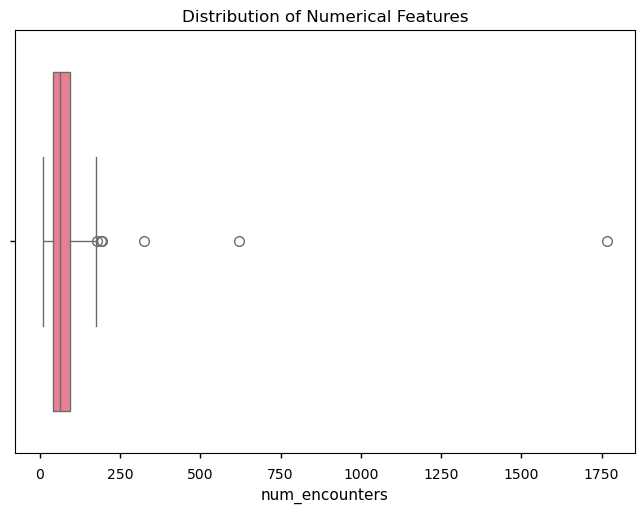

In [29]:
# Visualize distributions
plt.title("Distribution of Numerical Features")
sns.boxplot(x=df["num_encounters"])
plt.show()

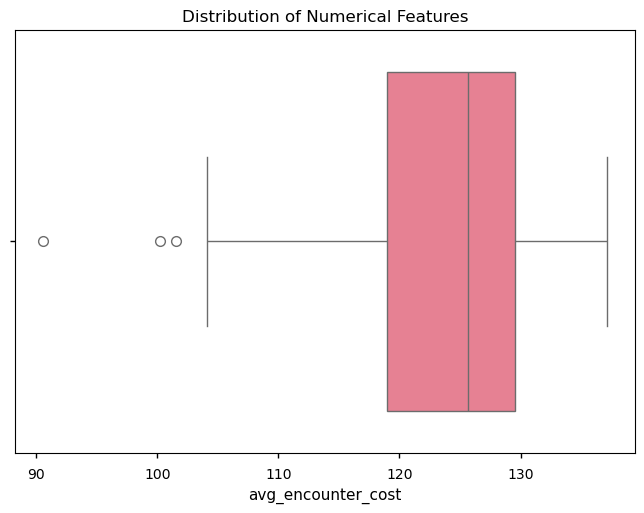

In [30]:
# Visualize distributions
plt.title("Distribution of Numerical Features")
sns.boxplot(x=df["avg_encounter_cost"])
plt.show()

In [49]:
def detect_outliers(df, numeric_cols):
    """Detect and visualize outliers"""
    print("\n🔎 Detecting outliers...")
    # Isolation Forest for outlier detection
    iso = IsolationForest(contamination=0.05, random_state=42)
    outliers = iso.fit_predict(df[numeric_cols])
    df["outlier_flag"] = outliers == -1

    print(f"\n❗ Detected {df['outlier_flag'].sum()} outliers")

    print(df["outlier_flag"])

    # # Outlier visualization
    # for col in df['outlier_flag'][:3]:  # Show first 3 features
    #     plt.figure(figsize=(10, 4))
    #     sns.boxplot(x=df[col])
    #     plt.title(f"Outliers in {col}")
    #     plt.tight_layout()
    #     plt.savefig(f"reports/figures/outliers_{col}.png")
    #     plt.show()

In [50]:
detect_outliers(df, numeric)


🔎 Detecting outliers...

❗ Detected 7 outliers
0      False
1      False
2      False
3      False
4      False
       ...  
135    False
136    False
137    False
138    False
139    False
Name: outlier_flag, Length: 140, dtype: bool


In [19]:
def preprocess_data(df, categorical, numeric):
    """Preprocess data with encoding and scaling"""
    print("\n⚙️ Preprocessing data...")

    # One-hot encode categorical
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_cat = encoder.fit_transform(df[categorical])
    X_cat_df = pd.DataFrame(X_cat, columns=encoder.get_feature_names_out(categorical))

    # Scale numeric features
    scaler = StandardScaler()
    X_num = scaler.fit_transform(df[numeric])
    X_num_df = pd.DataFrame(X_num, columns=numeric)

    # Combine features
    X = pd.concat(
        [X_cat_df.reset_index(drop=True), X_num_df.reset_index(drop=True)], axis=1
    )
    y = df["readmitted"]

    return X, y, encoder, scaler

## Preprocess data

In [51]:
# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = encoder.fit_transform(df[categorical])
X_cat_df = pd.DataFrame(X_cat, columns=encoder.get_feature_names_out(categorical))

In [52]:
# Scale numeric features
scaler = StandardScaler()
X_num = scaler.fit_transform(df[numeric])
X_num_df = pd.DataFrame(X_num, columns=numeric)

# Combine features
X = pd.concat(
    [X_cat_df.reset_index(drop=True), X_num_df.reset_index(drop=True)], axis=1
)
y = df[target]

In [53]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [54]:
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (112, 27)
Test set shape: (28, 27)


In [56]:
# Train model
print("\n🏋️ Training model...")
model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
model.fit(X_train, y_train)


🏋️ Training model...


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [57]:
# Generate predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [58]:
# Calculate metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

In [60]:
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

print(f"\n✅ Accuracy: {acc:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ ROC AUC: {roc:.4f}")


📋 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.40      0.53        20
           1       0.33      0.75      0.46         8

    accuracy                           0.50        28
   macro avg       0.57      0.57      0.50        28
weighted avg       0.67      0.50      0.51        28


✅ Accuracy: 0.5000
✅ F1 Score: 0.4615
✅ ROC AUC: 0.7750


In [66]:
# Enhanced Model Training
# Handle class imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [70]:
# Trying Random Forest which often performs better on imbalanced data
model = RandomForestClassifier(
    n_estimators=200, class_weight="balanced", random_state=42
)
model.fit(X_res, y_res)
# Generate predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [71]:
# Calculate metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

In [72]:
print("\n📋 Classification Report with RandomForest:")
print(classification_report(y_test, y_pred))

print(f"\n✅ Accuracy: {acc:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ ROC AUC: {roc:.4f}")


📋 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.70      0.76        20
           1       0.45      0.62      0.53         8

    accuracy                           0.68        28
   macro avg       0.64      0.66      0.64        28
weighted avg       0.72      0.68      0.69        28


✅ Accuracy: 0.6786
✅ F1 Score: 0.5263
✅ ROC AUC: 0.6437


In [73]:
# Trying XGBoost with scale_pos_weight
from xgboost import XGBClassifier

scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric="logloss"
)
xgb.fit(X_train, y_train)

ModuleNotFoundError: No module named 'xgboost'

In [74]:
# pip install xgboost

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 578.7 kB/s eta 0:04:19
   ---------------------------------------- 0.5/150.0 MB 578.7 kB/s eta 0:04:19
   ---------------------------------------- 0.5/150.0 MB 578.7 kB/s eta 0:04:19
   ---------------------------------------- 0.5/150.0 MB 578.7 kB/s eta 0:04:19
   ---------------------------------------- 0.5/150.0 MB 578.7 kB/s eta 0:04:19
   ---------------------------------------- 0.5/150.0 MB 578.7 kB/s eta 0:04:19
   -------------------

ERROR: Exception:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\ProgramData\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
                  ^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\http\client.py", line 479, in read
    s = self.fp.read(amt)
        ^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^

<Figure size 1000x400 with 0 Axes>

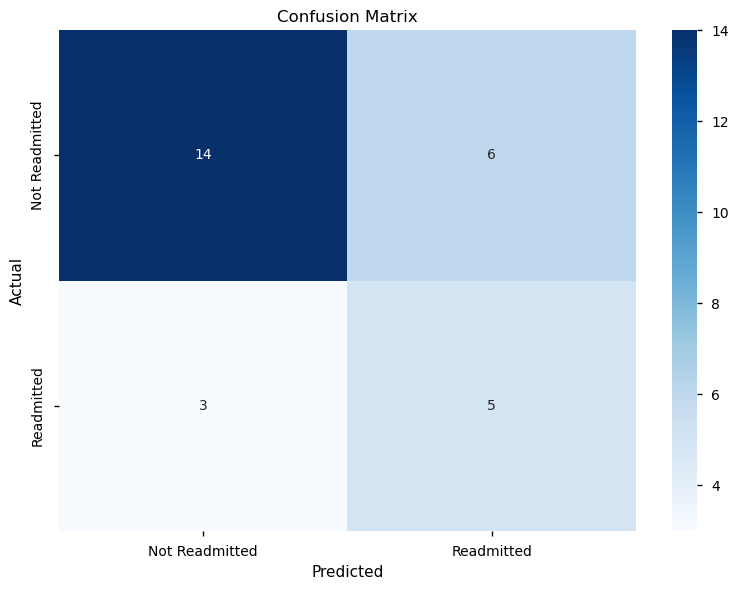

In [75]:
# Cell 12: Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Readmitted", "Readmitted"],
    yticklabels=["Not Readmitted", "Readmitted"],
)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

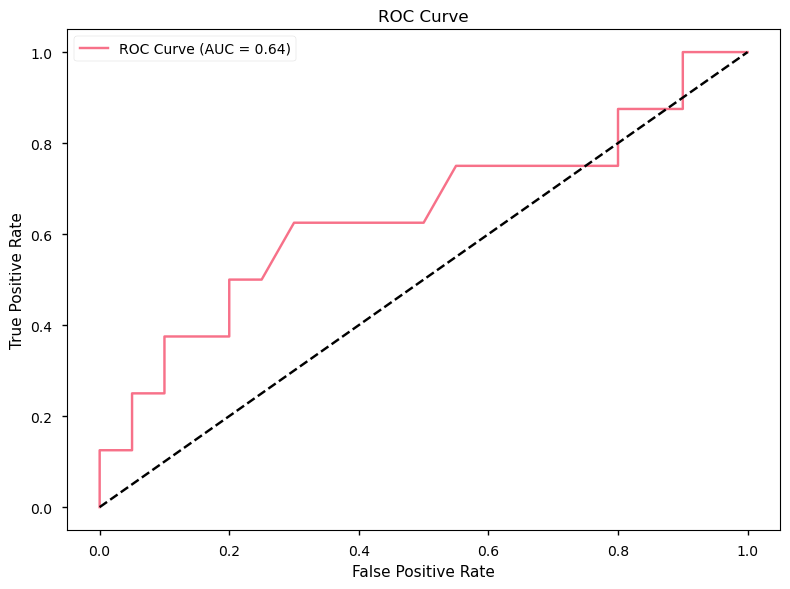

In [76]:
# %%
# Cell 13: ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

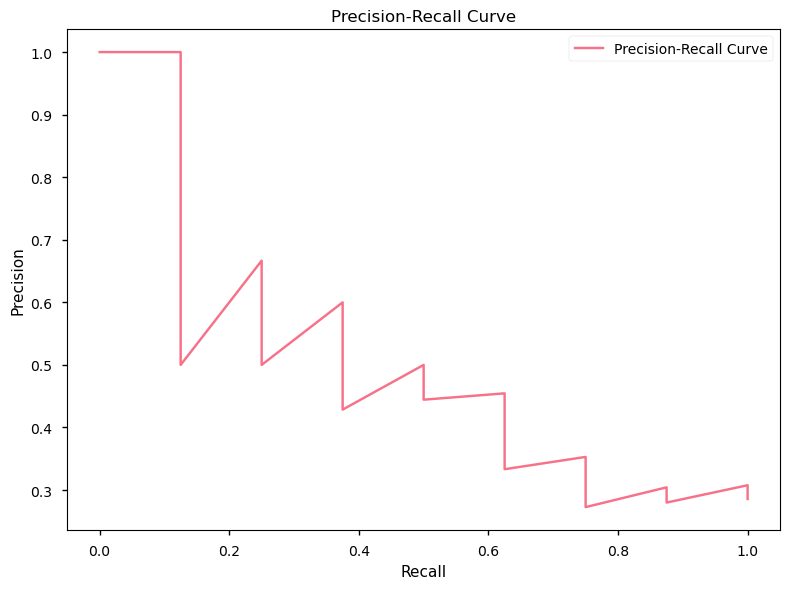

In [77]:
# %%
# Cell 14: Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()

In [116]:
""  # Cell Save artifacts
print("\n💾 Saving artifacts...")

joblib.dump(model, "../models/model.pkl")
joblib.dump(encoder, "../models/encoder.pkl")
joblib.dump(scaler, "../models/scaler.pkl")


💾 Saving artifacts...


['../models/scaler.pkl']